Basic underworld tutorial
======

Temperature gradient as steady state solution
----

This notebook is intended to give a quick overview of how to run underworld using ipython notebooks. It is the beginning of a series of tutorials which will increase in functionality. By the end of these tutorials the user should be able to tackle the more complex notebooks available in the **publications** directory. For more details on individual concepts the user is directed to notebooks in the **userguides** directory.

**This lesson introduces the concepts of:**
1. basics of underworld
2. setting up meshes (grids)
3. setting initial conditions
4. setting boundary conditions
5. solving Stokes system
6. plotting physical quantities on meshes
7. saving underworld variables to file



Load python functions needed for underworld.

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import numpy as np

Setup parameters
-----

Set physical values for test. Particularly the number of dimensions for the simulation (*dim*), simulation resolution (*res*) and simulation box height and lengths.

In [2]:
dim = 2
Box_Height = 1.0
Box_Length = 1.0
Temp_Min = 0.0
Temp_Max = 1.0
# set the resolution
res = 4

Create mesh and finite element variables
------

Create mesh objects. These store the indices and spatial coordiates of the grid points on the mesh.

In [3]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("Q1/dQ0"), 
                                         elementRes=(res,res), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(Box_Length, Box_Height))
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

** More information ** on meshes can be found in the **userguide** directory.

Create Finite Element (FE) variables for the velocity, pressure and temperature fields. The last two of these are scalar fields needing only one value at each mesh point, while the velocity field contains a vector of *dim* dimensions at each mesh point.

In [4]:
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

Set initial conditions and boundary conditions
----------

**Initial conditions**

Start with a the temperature field equal to zero everywhere except on the boundaries (below).

In [5]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.

**Boundary conditions**

Underworld includes functions for listing special sets of vertices on the mesh. To see the list of them run the following command

In [6]:
linearMesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

Here we set the temperature at the bottom of the simulation box to have the maximum temperature and the top of the box to have the minimum temperature.

The vertices on the mesh for the bottom of the simulation box are contained in "MinJ_VertexSet", those for the top are in "MaxJ_VertexSet".

In [7]:
for index in linearMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = Temp_Max
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = Temp_Min

**Conditions on the boundaries**

Construct sets for the both horizontal and vertical walls. Combine the sets of vertices to make the I (left and right side walls) and J (top and bottom walls) sets. Note that both sets contain the corners of the box.

In [8]:
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]

**Use sets to specify the type of boundary conditions**

**Underworld** needs to know what to do on the boundaries of the simulation box. The defaults boundary conditions on the variable itself; also called free-slip or Dirichlet boundary conditions. More information on Dirichlet boundary conditions can be found [here](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition), briefly these are any conditions of the form
\\[
y(a) = \alpha \quad \quad y(b) = \beta
\\]
which are set below for the velocity vector field and temperature scalar fields along the boundaries (IWalls, JWalls). The values for the boundaries are what ever is in the variables before this step, in this case the initial conditions set above. For example a set of tuples containing $v_x$ and $v_y$ for the velocity field will be preserved for all time on the boundaries (IWalls, JWalls) by the first command below. While the temperature is only held constant on the top and bottom boundaries (JWalls) by the second command below.

Note that through this function, we are flagging to the system that these vertices are to be considered as boundary conditions.

In [9]:
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              nodeIndexSets=(IWalls,JWalls) )
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              nodeIndexSets=(JWalls,) )

**Plot initial conditions for temperature**

The following cell uses the built in plotter (**gLucifer**) to plot the temperature field (initial conditions) and overlay it with the mesh.

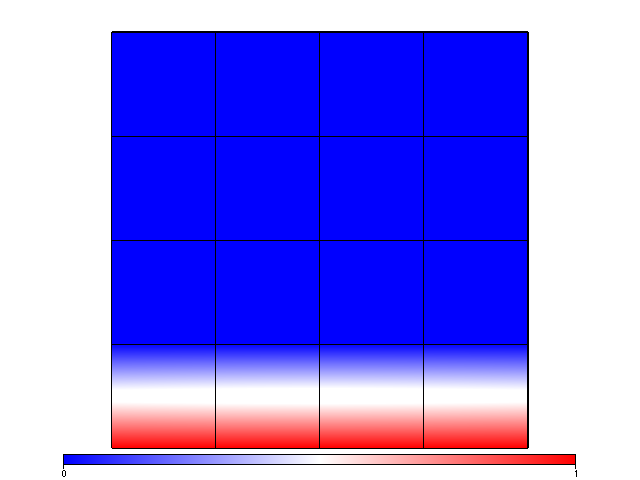

In [10]:
figtemp = plt.Figure()
figtemp.Surface(temperatureField, linearMesh, colours="blue white red")
figtemp.Mesh(linearMesh, colourBar = False)
figtemp.show()

Set up material parameters and functions
-----

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

Notes:
1. temperature must be in the range 0-1 for use with the denisity function defined using the Rayleigh number.
2. $\hat{z}$ (*z_hat*) denotes the positive vertical direction. 
3. The density ($\rho$) should be negatively proportional to the temperature field so that high temperature has low density.
4. Both $\hat{z}$ and $\rho$ are combined to define the buoyancy function which is used to set up the Stokes system.

In [11]:
# this can be replaced by a function
viscosityFn = fn.misc.constant(1.0)

# Rayleigh number
Ra = 1.0e6

# since Ra is a constant and temperature is a FEvariable, then densityFn will also be an FEvariable.
densityFn = -Ra * temperatureField

# define our vertical unit vector using a python tuple (this will be automatically converted to a function)
z_hat = ( 0.0, 1.0 )

# now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
# The result from which will also be a FEvariable.
buoyancyFn = densityFn * z_hat


In the cell above the *densityFn* and the *buoyancyFn* are written as functions of existing FE variables. This means that they will keep this functionality for the entire simulation. So the density will always be subject to this function.

By setting the system up in this way we only need to set these functions once at the beginning and not each timestep.

System setup
-----

**Setup a Stokes system**

Firstly, the velocity field, pressure, viscosity and buoyancy forces need to be passed to the Stokes system function. Along with the conditions affecting these variables - in this case the boundary conditions for the velocity field.

This system is solved after each time step using the .solve function (see main loop below).

In [12]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=viscosityFn, 
                              bodyForceFn=buoyancyFn )


**Create an advective-diffusive system**


Setup the system in underworld by flagging the temperature and velocity field variables as well as the temperature boundary conditions.

In [13]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=1., conditions=[tempBC,], )

Main time loop
-----

The main time stepping loop begins here. Before this the time and timestep are initialised to zero. For this particular example the simulation is run for long enough for the temperature field to come into steady-state with the top and bottom boundary conditions


In [14]:
time = 0.
steps = 0
steps_end = 1000
while steps < steps_end:
    # Get solution for initial configuration
    stokesPIC.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if steps == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    steps += 1

**Plot final temperature field**

The temperature field should now be in steady state. To check this we re-run the plotter used above.

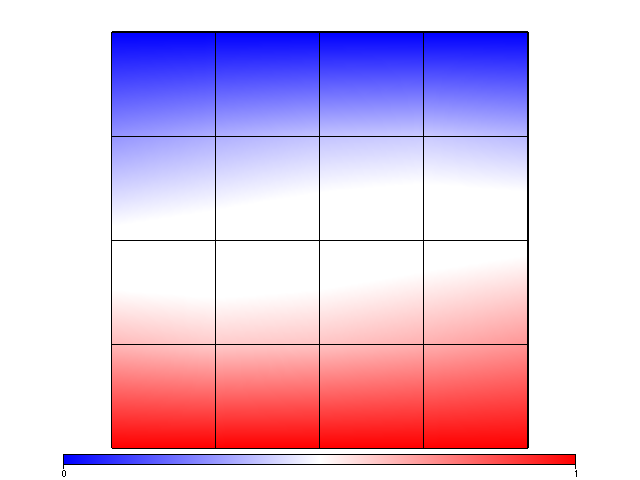

In [15]:
figtemp = plt.Figure()
figtemp.Surface(temperatureField, linearMesh, colours="blue white red")
figtemp.Mesh(linearMesh, colourBar = False)
figtemp.show()

The temperature field should be in steady-state, i.e. a smooth gradient from the top minimum temperature to the bottom maximum temperature.